# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Make bar plot

In [10]:
print( correlations["CSD"])
print(len(correlations))
print(correlations.axes)

0.0429475505192
67
[Index(['SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'AP Test Takers ',
       'Total Exams Taken', 'Number of Exams with scores 3 4 or 5',
       'Total Cohort', 'CSD', 'NUMBER OF STUDENTS / SEATS FILLED',
       'NUMBER OF SECTIONS', 'AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS',
       'SIZE OF LARGEST CLASS', 'SCHOOLWIDE PUPIL-TEACHER RATIO', 'schoolyear',
       'fl_percent', 'frl_percent', 'total_enrollment', 'ell_num',
       'ell_percent', 'sped_num', 'sped_percent', 'asian_num', 'asian_per',
       'black_num', 'black_per', 'hispanic_num', 'hispanic_per', 'white_num',
       'white_per', 'male_num', 'male_per', 'female_num', 'female_per', 'rr_s',
       'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11',
       'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_10', 'aca_t_11', 'saf_s_11',
       'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11',
       'eng_tot_11', 'aca_t

In [31]:
#for field in survey_fields:
#    if field == 'DBN':
#        continue
#    print( "Correlation between sat_score and {0}: {1}".format(field,correlations[field]) )

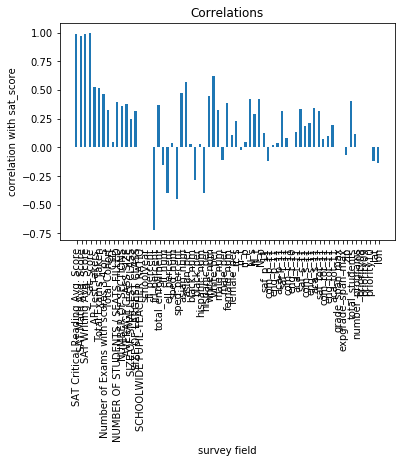

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

bar_heights = correlations
bar_positions = numpy.arange(len(correlations)) + 0.75
tick_positions = range(1,len(correlations)+1)
column_names = correlations.index.values.tolist()

fig, ax = plt.subplots()

ax.bar(bar_positions, bar_heights, 0.5)
ax.set_xticks(tick_positions)
ax.set_xticklabels(column_names, rotation=90)

ax.set_xlabel('survey field')
ax.set_ylabel('correlation with sat_score')
ax.set_title('Correlations')

plt.show()

# Correlations for Survey of parents teachers and students

In [12]:
#print( survey_fields )
print( correlations[survey_fields])

DBN                NaN
rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_10           NaN
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64


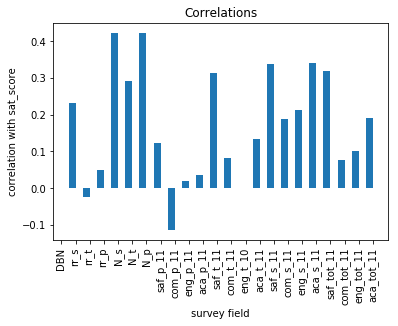

In [13]:
bar_heights = correlations[ survey_fields ]
bar_positions = numpy.arange(len( survey_fields )) + 0.75
tick_positions = range(1,len( survey_fields )+1)
#column_names = correlations.index.values.tolist()

fig, ax = plt.subplots()

ax.bar(bar_positions, bar_heights, 0.5)
ax.set_xticks(tick_positions)
ax.set_xticklabels(survey_fields, rotation=90)

ax.set_xlabel('survey field')
ax.set_ylabel('correlation with sat_score')
ax.set_title('Correlations')

plt.show()

Plot correlation saftey rating (students) saf_s_11 and SAT score:

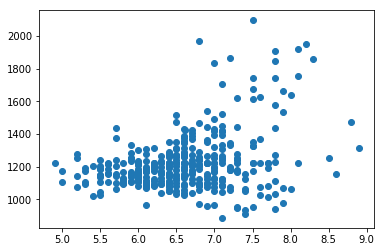

In [14]:
plt.plot(combined["saf_s_11"], combined["sat_score"], linestyle='none',marker='o')
plt.show()

Get average safety score per district and map it:

In [15]:
safe_dist = combined.groupby("school_dist").agg( numpy.mean )[ ["saf_s_11", "lat", "lon"] ]

In [16]:
print(safe_dist)

             saf_s_11        lat        lon
school_dist                                
01           6.768611  40.719022 -73.982377
02           6.910660  40.739699 -73.991386
03           6.716667  40.781574 -73.977370
04           6.885714  40.793449 -73.943215
05           6.314286  40.817077 -73.949251
06           6.950000  40.848970 -73.932502
07           6.800000  40.816815 -73.919971
08           6.364697  40.823803 -73.866087
09           6.655000  40.836349 -73.906240
10           6.577273  40.870345 -73.898360
11           6.186667  40.873138 -73.856120
12           7.116667  40.831412 -73.886946
13           6.407692  40.692865 -73.977016
14           6.685714  40.711599 -73.948360
15           6.177778  40.675972 -73.989255
16           5.875000  40.688008 -73.929686
17           6.007143  40.660313 -73.955636
18           6.190909  40.641863 -73.914726
19           6.150000  40.676547 -73.882158
20           7.120000  40.626751 -74.006191
21           6.390909  40.593596

In [17]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)



longitudes = safe_dist["lon"].tolist()
latitudes = safe_dist["lat"].tolist()

m.scatter( longitudes, latitudes, s=20, zorder=2, latlon=True, c=safe_dist["saf_s_11"], cmap="summer" )

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

Explore ratial correlations:

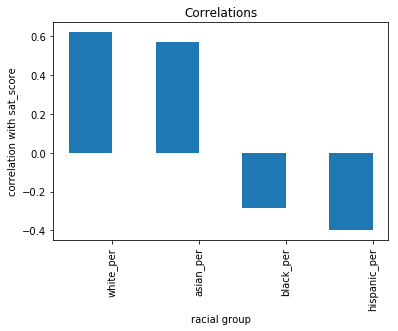

In [21]:
race_fields = ["white_per","asian_per","black_per","hispanic_per"]

bar_heights = correlations[ race_fields ]
bar_positions = numpy.arange(len( race_fields )) + 0.75
tick_positions = range(1,len( race_fields )+1)
#column_names = correlations.index.values.tolist()

fig, ax = plt.subplots()

ax.bar(bar_positions, bar_heights, 0.5)
ax.set_xticks(tick_positions)
ax.set_xticklabels(race_fields, rotation=90)

ax.set_xlabel('racial group')
ax.set_ylabel('correlation with sat_score')
ax.set_title('Correlations')

plt.show()

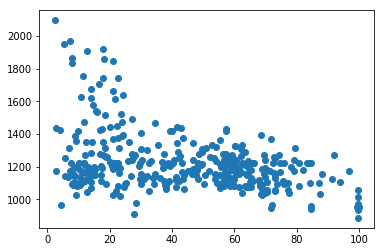

In [22]:
plt.plot(combined["hispanic_per"], combined["sat_score"], linestyle='none',marker='o')
plt.show()

Check correlations with gender:

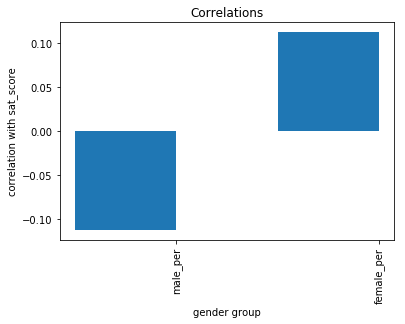

In [23]:
gender_fields = ["male_per","female_per"]

bar_heights = correlations[ gender_fields ]
bar_positions = numpy.arange(len( gender_fields )) + 0.75
tick_positions = range(1,len( gender_fields )+1)
#column_names = correlations.index.values.tolist()

fig, ax = plt.subplots()

ax.bar(bar_positions, bar_heights, 0.5)
ax.set_xticks(tick_positions)
ax.set_xticklabels(gender_fields, rotation=90)

ax.set_xlabel('gender group')
ax.set_ylabel('correlation with sat_score')
ax.set_title('Correlations')

plt.show()

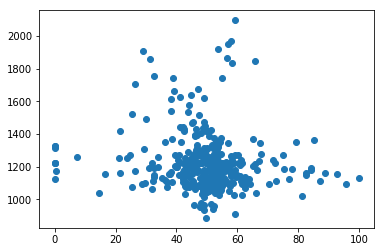

In [24]:
plt.plot(combined["male_per"], combined["sat_score"], linestyle='none',marker='o')
plt.show()

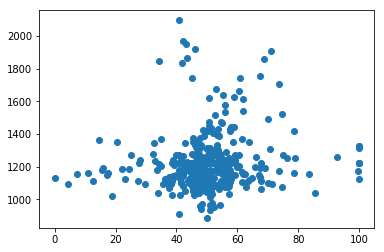

In [25]:
plt.plot(combined["female_per"], combined["sat_score"], linestyle='none',marker='o')
plt.show()

Check correlation between AP placement exams and SAT scores:

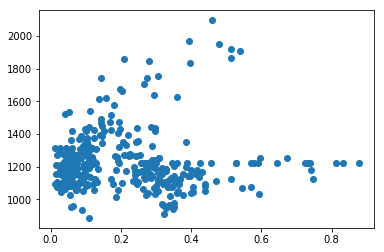

In [26]:
# Normalize AP test takers number to total enrollment and add column
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

plt.plot(combined["ap_per"], combined["sat_score"], linestyle='none',marker='o')
plt.show()

We've done quite a bit of investigation into relationships between demographics and SAT scores in this guided project. There's still quite a bit of analysis left to do, however. Here are some potential next steps:

Determing wheter there's a correlation between class size and SAT scores
Figuring out which neighborhoods have the best schools
If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
Investigating the differences between parent, teacher, and student responses to surveys.
Assigning scores to schools based on sat_score and other attributes.
We recommend creating a GitHub repository and placing this project there. It will help other people see your work, including employers. As you start to put multiple projects on GitHub, you'll have the beginnings of a strong portfolio.

You're welcome to keep working on the project here, but we recommend downloading it to your computer using the download icon above and working on it there.